# Simulating some value to figure out where our limitation are


In [1]:
import scipy.constants as cont
import numpy as np
from scipy.fft import fft, fftfreq

import copy
import pandas as pd
from uncertainties import ufloat
from uncertainties.umath import *

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from fticr_toolkit import ame
from fticr_toolkit import ideal_trap_physics as ideal
from fticr_toolkit import systematics as sys_fun

In [2]:
LO = 700e3
RF = 730e3
fcenter = RF-LO
SAMPLING_RATE = 1000e6 # samples per second
SAMPLING_RATE_SOUNDCARD = 192000
print(1/SAMPLING_RATE, 1/SAMPLING_RATE_SOUNDCARD, SAMPLING_RATE/SAMPLING_RATE_SOUNDCARD)

aLO = 10
aRF = 1
length = 10e-3
t=np.arange(0,length,1/SAMPLING_RATE) # sampling rate of the LO!!! not of the soundcard!
sLO=aLO*np.sin(2*np.pi*t*LO) # signal data (basically time domain data)

zero_t = 0.05 - length

1e-09 5.208333333333333e-06 5208.333333333333


5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200
5208.333333333333 5208 3200


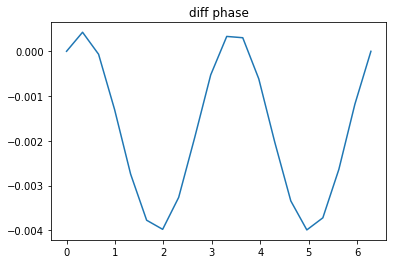

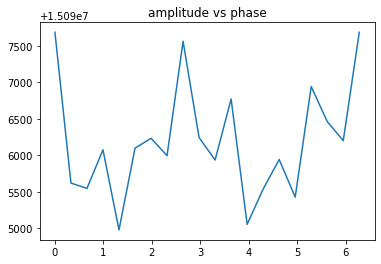

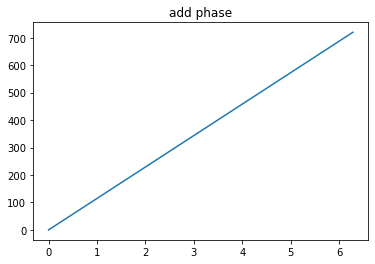

In [3]:
phases = np.linspace(0, 2*np.pi, 20)
read_phase = []
read_amp = []
for phase in phases:
    pRF = phase # phase offset
    sRF=aRF*np.sin(2*np.pi*t*RF+pRF) # signal data (basically time domain data)
    
    # mixing & normalizing
    sMI = sRF*sLO
    
    #plt.plot(t[:10000], sMI[:10000])
    #plt.show()
    sMI = np.int16((sMI / sMI.max()) * 32767)

    # zero padding
    signal = np.append(sMI, np.zeros(int(zero_t*SAMPLING_RATE), dtype=np.int16) )
    
    # resampling with slower soundcard:
    old_N = len(signal)
    # ether picking the samples
    #signal = signal[::int(SAMPLING_RATE/SAMPLING_RATE_SOUNDCARD)]
    
    # or mean the sub arrays
    sampling_ratio = SAMPLING_RATE/SAMPLING_RATE_SOUNDCARD
    mean_size = int(sampling_ratio)
    over_cut = old_N%mean_size
    print(sampling_ratio, mean_size, over_cut)
    if over_cut != 0:
        signal = np.mean(signal[:-over_cut].reshape(-1, mean_size), axis=1)
    else:
        signal = np.mean(signal.reshape(-1, mean_size), axis=1)

        
    #plt.plot(signal[:100])
    #plt.show()
    
    # Number of samples 
    N = len(signal)
    #print('original N', old_N, 'down sampled', N)

    # Fourier transform
    yf = fft(signal)
    xf = fftfreq(N, 1 / SAMPLING_RATE_SOUNDCARD)

    # where to look
    idx_conv = (np.abs(xf - fcenter)).argmin()
    #print(idx_conv, xf[idx_conv])
    
    # get phase
    rp = np.angle(yf[idx_conv])
    if rp < 0:
        rp +=2*np.pi
    #print('rfphase', phase, 'fft phase', rp)
    read_phase.append( rp )
    read_amp.append( np.abs(yf[idx_conv]) )

#plt.plot(read_phase)
#plt.show()
read_phase = np.unwrap(read_phase)
#plt.plot(read_phase)
#plt.show()
read_phase -= read_phase.min()
#plt.plot(read_phase)
#plt.show()
diff_phase = phases - read_phase
plt.plot(phases, diff_phase/2/np.pi*360)
plt.title("diff phase")
plt.show()
plt.plot(phases, read_amp)
plt.title("amplitude vs phase")
plt.show()

add_phase = phases + read_phase
add_phase -= add_phase.min()
plt.plot(phases, add_phase/2/np.pi*360)
plt.title("add phase")
plt.show()

## resonator excitation due to coupling pulse and **just** the underlying signal (no axial excitation)

1 0.05623413251903491
rfphase 0.0 fft phase 0.07345355746288434 fft amp 15723394.55266967
rfphase 0.3306939635357677 fft phase 0.3888632700250256 fft amp 15725023.634750433
rfphase 0.6613879270715354 fft phase 0.7023236137827324 fft amp 15725864.922893886
rfphase 0.992081890607303 fft phase 1.015465162369579 fft amp 15725816.690732233
rfphase 1.3227758541430708 fft phase 1.3299384433528254 fft amp 15725029.713288927
rfphase 1.6534698176788385 fft phase 1.6473310184953982 fft amp 15724015.045093125
rfphase 1.984163781214606 fft phase 1.9690555535059375 fft amp 15723075.721044127
rfphase 2.3148577447503738 fft phase 2.2962248726879833 fft amp 15720747.32327823
rfphase 2.6455517082861415 fft phase 2.6294809307941707 fft amp 15721055.539699584
rfphase 2.9762456718219092 fft phase 2.9688371386031895 fft amp 15721896.306806121
rfphase 3.306939635357677 fft phase 3.313534920267826 fft amp 15725011.85612974
rfphase 3.6376335988934447 fft phase 3.6620397264685183 fft amp 15725180.441086465
rfph

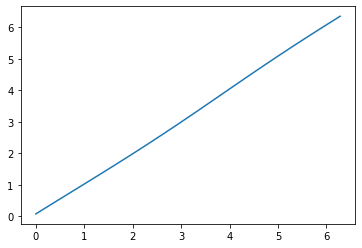

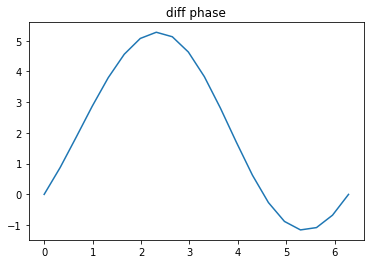

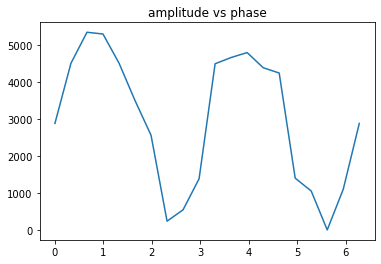

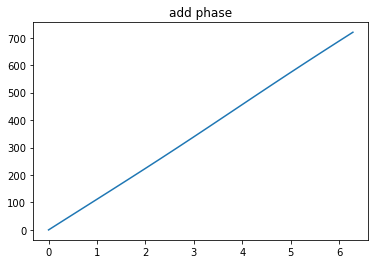

In [4]:
phases = np.linspace(0, 2*np.pi, 20)
read_phase = []
read_amp = []

dbRES = -25
aRES = aRF*10**(dbRES/20)
print(aRF, aRES)
sRES=aRES*np.sin( 2*np.pi*t*RF+130/360*2 )

for phase in phases:
    pRF = phase # phase offset
    sRF=aRF*np.sin(2*np.pi*t*RF+pRF) # signal data (basically time domain data)
    #plt.plot(t[:10000], sRF[:10000])

    # adding resonator signal
    sADDED = sRF + sRES
    #plt.plot(t[:10000], sRF[:10000])
    #plt.show()
    
    # mixing & normalizing
    sMI = sADDED*sLO
    
    sMI = np.int16((sMI / sMI.max()) * 32767)

    # zero padding
    signal = np.append(sMI, np.zeros(int(zero_t*SAMPLING_RATE), dtype=np.int16) )
    
    # resampling with slower soundcard:
    old_N = len(signal)
    # ether picking the samples
    signal = signal[::int(SAMPLING_RATE/SAMPLING_RATE_SOUNDCARD)]
    
    # or mean the sub arrays
    sampling_ratio = SAMPLING_RATE/SAMPLING_RATE_SOUNDCARD
    mean_size = int(sampling_ratio)
    over_cut = old_N%mean_size
    #print(sampling_ratio, mean_size, over_cut)
    #if over_cut != 0:
    #    signal = np.mean(signal[:-over_cut].reshape(-1, mean_size), axis=1)
    #else:
    #    signal = np.mean(signal.reshape(-1, mean_size), axis=1)

        
    #plt.plot(signal[:100])
    #plt.show()
    
    # Number of samples 
    N = len(signal)
    #print('original N', old_N, 'down sampled', N)

    # Fourier transform
    yf = fft(signal)
    xf = fftfreq(N, 1 / SAMPLING_RATE_SOUNDCARD)

    # where to look
    idx_conv = (np.abs(xf - fcenter)).argmin()
    #print(idx_conv, xf[idx_conv])
    
    # get phase
    rp = np.angle(yf[idx_conv])
    if rp < 0:
        rp +=2*np.pi
    amp = np.abs( yf[idx_conv] )
    print('rfphase', phase, 'fft phase', rp, "fft amp", amp )
    read_phase.append( rp )
    read_amp.append( amp )

#plt.plot( read_phase )
#plt.show()
read_phase = np.unwrap( read_phase )
plt.plot(phases, read_phase)
plt.show()
read_phase -= read_phase.min()
#plt.plot(read_phase)
#plt.show()
diff_phase = phases - read_phase
plt.plot(phases, diff_phase/2/np.pi*360)
plt.title("diff phase")
plt.show()

# normalize amp
read_amp -= np.min(read_amp)
plt.plot(phases, read_amp)
plt.title("amplitude vs phase")
plt.show()

add_phase = phases + read_phase
add_phase -= add_phase.min()
plt.plot(phases, add_phase/2/np.pi*360)
plt.title("add phase")
plt.show()

### Thats it?

This could be it. This is an underlying signal due to excitation of the resonator. 

#### But it is not (kind of):
We tested this and the resonator signal relaxes ultra fast. In combination with our fft_delay of 5 ms (waiting after the coupling pulse before we start acquiring the signal) the resonator signal is long gone. How did we test it? We increased the fft delay step by step up to 100 milliseconds and checked how the non-linear phase effect changes. If it would be the underlying signal of the resonator, which is definitly at some rate relaxing, the amplitude of this non linear phase effect would have to decrease. That was not the case. This supports the idea that the real phase of the ion is effected, either radially or axially.

#### Still:
Since we see this excitation of the resonator (with a fixed phase due to the phase of the coupling pulse) it might be possible that its still in some way the origin, e.g. by exciting the axial motion. If this is the case the axial phase will be effected directly at the time of the coupling and the effect will not change with longer fft delay. So that would fit. So how do we test that? Two possibilities: off resonant measurement, which might be less effected by the resonator signal or **shaping the pulse** (like Sven suggested) with a **window function** to reduce the amplitude of the slopes (see FFT) and theirby not excite the resonator. **This was successfully tested and the theory correct!**


## Another prospect due to this:

Since the axial frequency modifies the phase on readout, we can also check the jitter of the phase readout due to a random phase in the axial mode:

What we see when executig the cells below is that with routhly -16dB axial signal with a random phase we get the phase jitter of 7/8 degree we typically see.

**What we also see**
If we somehow fix this phase, e.g. by an axial excitation just before the coupling, we would go down to sub degree stability even with a SNR of just -5 db.
**AMAZING**

154.9769791015815 107.95933132529028


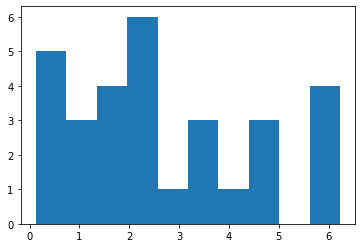

In [5]:
axial_phases = np.random.rand(30)*2*np.pi
#axial_phases = np.random.rand(30)*2*np.pi/180 # make it stable to 2 degree by axial excitation just before the coupling.
print(np.mean(axial_phases)*180/np.pi, np.std(axial_phases)*180/np.pi)
plt.hist(axial_phases)
plt.show()

1 0.7079457843841379 0.7079457843841379
rfphase 0.384120252872005 fft phase 0.19661742280749944 fft amp 15723345.731582489
rfphase 5.663766348468221 fft phase 6.065911830548887 fft amp 15721649.488798006
rfphase 1.843523909016687 fft phase 0.737766081457146 fft amp 15725288.18474125
rfphase 1.7575772774057439 fft phase 0.7129994134140407 fft amp 15726720.523113146
rfphase 3.786357998225541 fft phase 5.545533060770486 fft amp 15720770.939886386
rfphase 0.4904577789559379 fft phase 0.24025240009383714 fft amp 15723601.28373294
rfphase 3.311760643485094 fft phase 5.94334287564754 fft amp 15721054.485529091
rfphase 0.7699208666270602 fft phase 0.3535658420045734 fft amp 15725695.633178057
rfphase 0.24896926072570852 fft phase 0.14088934061812275 fft amp 15723420.906584404
rfphase 4.9982986978619985 fft phase 5.805723578538521 fft amp 15720629.256992392
rfphase 4.979290008613243 fft phase 5.798729186082072 fft amp 15720732.223553475
rfphase 0.12429851809197645 fft phase 0.08930798214955939 

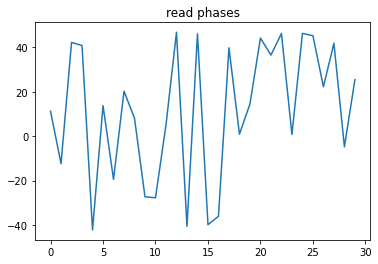

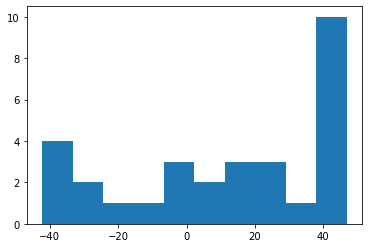

-3 11.605034686158852 30.167180232886686
1 0.5011872336272722 0.5011872336272722
rfphase 0.384120252872005 fft phase 0.16533344559655566 fft amp 15724099.455386076
rfphase 5.663766348468221 fft phase 6.117188553406882 fft amp 15721654.263085756
rfphase 1.843523909016687 fft phase 0.5466984927908342 fft amp 15724989.214736834
rfphase 1.7575772774057439 fft phase 0.5352013336321502 fft amp 15726050.915132761
rfphase 3.786357998225541 fft phase 5.855255156441954 fft amp 15720866.500703136
rfphase 0.4904577789559379 fft phase 0.2000578641929078 fft amp 15723482.87556678
rfphase 3.311760643485094 fft phase 6.154795442300383 fft amp 15722089.502063708
rfphase 0.7699208666270602 fft phase 0.2889225849716251 fft amp 15723871.270298617
rfphase 0.24896926072570852 fft phase 0.12072781536977854 fft amp 15723868.931090457
rfphase 4.9982986978619985 fft phase 5.922198697846518 fft amp 15722017.066931382
rfphase 4.979290008613243 fft phase 5.917360461121785 fft amp 15722750.78742862
rfphase 0.124298

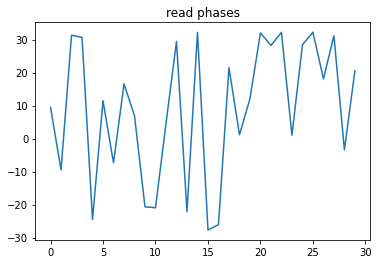

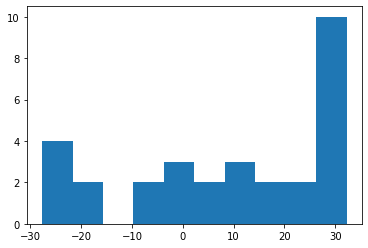

-6 8.95531438806315 20.47641897883023
1 0.31622776601683794 0.31622776601683794
rfphase 0.384120252872005 fft phase 0.1291822181781312 fft amp 15724640.50573776
rfphase 5.663766348468221 fft phase 6.175997890571348 fft amp 15722440.44511159
rfphase 1.843523909016687 fft phase 0.3591357292765574 fft amp 15724936.623324618
rfphase 1.7575772774057439 fft phase 0.3566277687905674 fft amp 15725275.88732134
rfphase 3.786357998225541 fft phase 6.07189848132443 fft amp 15721440.059868883
rfphase 0.4904577789559379 fft phase 0.15374062412814246 fft amp 15723171.24645173
rfphase 3.311760643485094 fft phase 6.2433361642380305 fft amp 15722620.11102308
rfphase 0.7699208666270602 fft phase 0.21529695065293034 fft amp 15725029.784542624
rfphase 0.24896926072570852 fft phase 0.09737117740430845 fft amp 15723096.450930841
rfphase 4.9982986978619985 fft phase 6.049290174498427 fft amp 15722853.618889539
rfphase 4.979290008613243 fft phase 6.0465072706721 fft amp 15722461.944069525
rfphase 0.12429851809

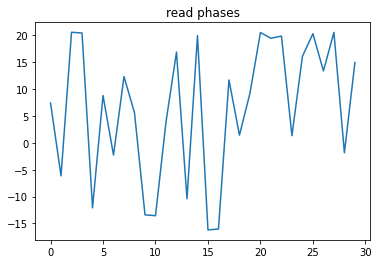

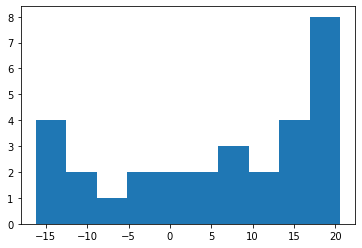

-10 6.422573552513849 12.542170587447746
1 0.15848931924611134 0.15848931924611134
rfphase 0.384120252872005 fft phase 0.08953625521096158 fft amp 15723745.569799712
rfphase 5.663766348468221 fft phase 6.239661621097503 fft amp 15722901.631457603
rfphase 1.843523909016687 fft phase 0.1959029689099587 fft amp 15723322.093439499
rfphase 1.7575772774057439 fft phase 0.19689642567618174 fft amp 15723340.801449409
rfphase 3.786357998225541 fft phase 6.212336126213803 fft amp 15722079.301410249
rfphase 0.4904577789559379 fft phase 0.10320288750035041 fft amp 15722876.039218528
rfphase 3.311760643485094 fft phase 0.006000340439263305 fft amp 15722739.316336589
rfphase 0.7699208666270602 fft phase 0.1365263377302274 fft amp 15723698.876207145
rfphase 0.24896926072570852 fft phase 0.0716384236983672 fft amp 15723199.281287115
rfphase 4.9982986978619985 fft phase 6.176438130779 fft amp 15722513.531712739
rfphase 4.979290008613243 fft phase 6.175267700157047 fft amp 15722374.174416296
rfphase 0.1

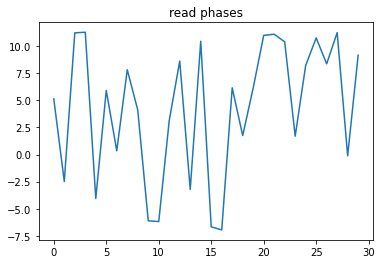

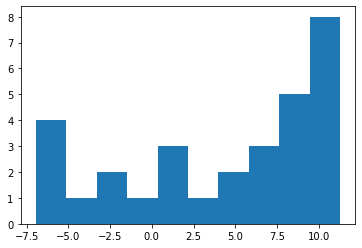

-16 4.27345226154182 6.15721108599575
1 0.1 0.1
rfphase 0.384120252872005 fft phase 0.07208043184315788 fft amp 15723248.930170322
rfphase 5.663766348468221 fft phase 6.267346749933811 fft amp 15723048.151650347
rfphase 1.843523909016687 fft phase 0.13644806823265235 fft amp 15723719.672233347
rfphase 1.7575772774057439 fft phase 0.13758584909762747 fft amp 15723609.599231701
rfphase 3.786357998225541 fft phase 6.255750339457293 fft amp 15722249.380178731
rfphase 0.4904577789559379 fft phase 0.08105678560855274 fft amp 15724401.923676439
rfphase 3.311760643485094 fft phase 0.019012694847237065 fft amp 15722530.385795578
rfphase 0.7699208666270602 fft phase 0.10265301418240293 fft amp 15722895.070091935
rfphase 0.24896926072570852 fft phase 0.060258617583004256 fft amp 15722673.69515124
rfphase 4.9982986978619985 fft phase 6.227938598214671 fft amp 15723542.578575151
rfphase 4.979290008613243 fft phase 6.227271176268843 fft amp 15723462.21163133
rfphase 0.12429851809197645 fft phase 0.0

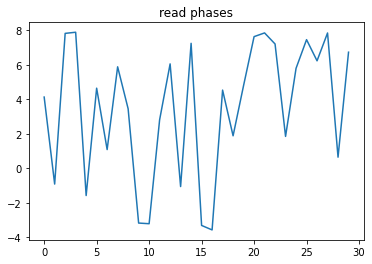

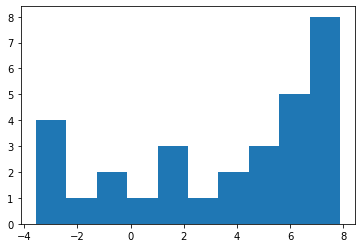

-20 3.489307172597613 3.859385839988307
1 3.1622776601683795e-05 3.1622776601683795e-05
rfphase 0.384120252872005 fft phase 0.037809785690792345 fft amp 15724451.783082802
rfphase 5.663766348468221 fft phase 0.03777915870597891 fft amp 15724439.421979127
rfphase 1.843523909016687 fft phase 0.037828589696303386 fft amp 15724453.72265485
rfphase 1.7575772774057439 fft phase 0.03782959752049958 fft amp 15724451.80855526
rfphase 3.786357998225541 fft phase 0.037778291293439986 fft amp 15724439.74224224
rfphase 0.4904577789559379 fft phase 0.03781287641439471 fft amp 15724450.089495035
rfphase 3.311760643485094 fft phase 0.03779218665058037 fft amp 15724454.408452513
rfphase 0.7699208666270602 fft phase 0.037819969270542965 fft amp 15724435.54408177
rfphase 0.24896926072570852 fft phase 0.03780538945025262 fft amp 15724450.336925033
rfphase 4.9982986978619985 fft phase 0.03776780605397764 fft amp 15724455.596535018
rfphase 4.979290008613243 fft phase 0.03776766050515083 fft amp 15724457.409

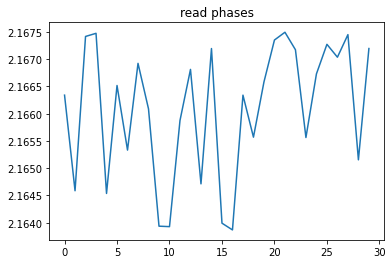

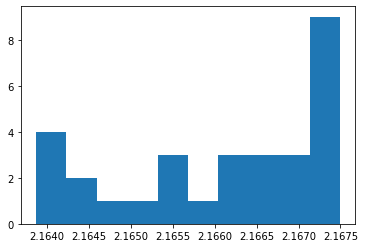

-90 2.166082438443483 0.0012179177697769243


In [6]:
dblist = [-3, -6, -10, -16, -20, -90]

mean_phases = []
std_phases = []

for db in dblist:

    dbAXIAL = db
    aAXIAL = aRF*10**(dbAXIAL/20)
    print(aRF, aAXIAL, aAXIAL/aRF)

    sRF=aRF*np.sin(2*np.pi*t*RF) # signal data (basically time domain data)

    read_phase = []
    read_amp = []

    for phase in axial_phases:
        sAXIAL=aAXIAL*np.sin( 2*np.pi*t*RF + phase)
        #plt.plot(t[:10000], sRF[:10000])

        # adding resonator signal
        sADDED = sRF + sAXIAL
        #plt.plot(t[:10000], sRF[:10000])
        #plt.show()

        # mixing & normalizing
        sMI = sADDED*sLO

        sMI = np.int16((sMI / sMI.max()) * 32767)

        # zero padding
        signal = np.append(sMI, np.zeros(int(zero_t*SAMPLING_RATE), dtype=np.int16) )

        # resampling with slower soundcard:
        old_N = len(signal)
        # ether picking the samples
        signal = signal[::int(SAMPLING_RATE/SAMPLING_RATE_SOUNDCARD)]

        # or mean the sub arrays
        sampling_ratio = SAMPLING_RATE/SAMPLING_RATE_SOUNDCARD
        mean_size = int(sampling_ratio)
        over_cut = old_N%mean_size
        #print(sampling_ratio, mean_size, over_cut)
        #if over_cut != 0:
        #    signal = np.mean(signal[:-over_cut].reshape(-1, mean_size), axis=1)
        #else:
        #    signal = np.mean(signal.reshape(-1, mean_size), axis=1)


        #plt.plot(signal[:100])
        #plt.show()

        # Number of samples 
        N = len(signal)
        #print('original N', old_N, 'down sampled', N)

        # Fourier transform
        yf = fft(signal)
        xf = fftfreq(N, 1 / SAMPLING_RATE_SOUNDCARD)

        # where to look
        idx_conv = (np.abs(xf - fcenter)).argmin()
        #print(idx_conv, xf[idx_conv])

        # get phase
        rp = np.angle(yf[idx_conv])
        if rp < 0:
            rp +=2*np.pi
        amp = np.abs( yf[idx_conv] )
        print('rfphase', phase, 'fft phase', rp, "fft amp", amp )
        read_phase.append( rp )
        read_amp.append( amp )

    read_phase = np.unwrap( read_phase ) * 180/np.pi
    plt.title("read phases")
    plt.plot(read_phase)
    plt.show()

    plt.hist(read_phase)
    plt.show()
    mean = np.mean(read_phase)
    std = np.std(read_phase)
    print(db, mean, std)
    mean_phases.append(mean)
    std_phases.append(std)
    


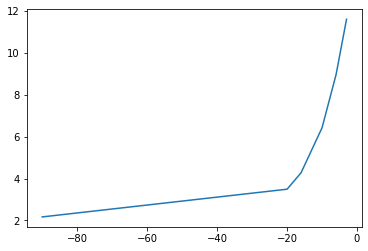

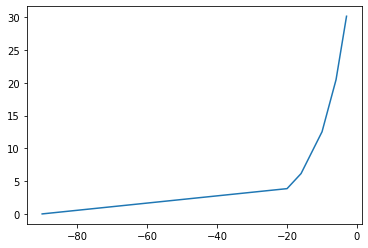

In [7]:


plt.plot(dblist, np.unwrap(np.asarray(mean_phases)/180*np.pi)*180/np.pi)
plt.show()
plt.plot(dblist, std_phases)
plt.show()

## What happens if I have a periodic waiting time (accumulation time) error?

First: How can this happen? If you transfere your waiting time to anouther unit, being samples of the function generator, where you have not only a time-quantization due to the sampling rate (500 MSa/s -> 2 ns/Sample) but maybe also programming limitations, like a minimal size for a arbitrary signal segment of 12 samples -> 24 ns (given by the function generator) or in the arbitrary script itself some rounding/conversion errors in that case.

Lets assume we do our non-linearity check measurement: We find a few PATs (in ms steps oor higher so we can ignore the local oszillator) with which we span the 2pi range for the current ions frequency / phase readout. Then we want to see either a flat line of phase - phase residuals or the discussed sinusoidial effekt. But what if we have PAT errors? How does the data look like and can we by accident create a sinusoidial like result?

In [8]:
# lets prepare the PATs like we would for a measurement, but also later much much more for easier check...
RF_SAMPLE_RATE = 500e6
MAX_SEQ_COUNT = int(1e6) 
MIN_SEQ_MEMORY_POINTS = int(32)

freq = fcyclotron
freq = 25070660.855
print("frequency", freq)
PATs = np.arange(1,1.1,0.004)
#PATs = np.arange(1,1.1,2e-9)
phases = ( freq * PATs ) % (2*np.pi)
plt.plot(PATs, phases)
plt.show()
plt.hist(phases, 100)
plt.show()

NameError: name 'fcyclotron' is not defined

In [ ]:
# convert PATs to samples and back:
def time_to_samples(time):
    return np.round(RF_SAMPLE_RATE * time).astype('int')

def time_to_segment(time)
    samples = time_to_samples(time)
    segments = []
    
    for these_samples in samples:
        if these_samples / MAX_SEQ_COUNT < MIN_SEQ_MEMORY_POINTS:
            while True:
                segment_repetition = total_samples / min_segment_size
                if round(segment_repetition,9) % 1 !=0: #check if the number is integer
                    min_segment_size += 1
                    continue
                else:
                    wait_pulse = (int(min_segment_size), int(segment_repetition))
                break
        else:
            while True:
                samples_in_segment = total_samples / segment_repetition
                if round(samples_in_segment,9) % 1 !=0: #check if the number is integer
                    segment_repetition -= 10 #ideally it should be -=1, but it seems to be working with 10, saving the computational time
                    continue
                else:
                    wait_pulse = (int(samples_in_segment), int(segment_repetition))
                break
        segments.append(wait_pulse)
    return segments
        
def samples_to_time(samples):
    return np.round(samples / RF_SAMPLE_RATE,9)

In [ ]:
PATSa = time_to_samples(PATs)
diff_PATs = samples_to_time(PATSa) - PATs
plt.plot(diff_PATs)

### So, the conversion is fine for ms steps

But for 4e-6 s steps it becomes a 1e-12 seconds error (which is very wierd) and for 4e-9 / 2e-9 s steps it becomes a 1e-9 seconds error (please try it out)

In [ ]:
# lets prepare the PATs like we would for a measurement, but also later much much more for easier check...

mfreq = freq - 0.01
print("frequency", mfreq)
mphases = ( mfreq * PATs ) % (2*np.pi)
plt.plot(mphases, phases)
plt.show()
plt.plot(phases, mphases-phases)
plt.show()

In [ ]:
from scipy.signal import windows
plt.rcParams["figure.figsize"] = (20,10)

RF = 20e6
LO = 20.01e6
f_sideband = LO - RF
SR = 200e6
pi_time = 16e-3
print("RF", RF, "LO", LO, "f_sideband", f_sideband, "SR", SR, "pi time", pi_time)

window_types = [["no window", 1], [("hamming"), 1], [("blackman"), 1], [("hann"), 1], [("tukey", 0.5), 1], [("flattop"), 1]]
window_types = [["no window", 1], [("hann"), 2.14], [("tukey", 0.5), 1.335], [("flattop"), 4.62]]
window_types = [["no window", 1], [("flattop"), 4.62], [("hann"), 2.14],  [("tukey", 0.5), 1.335]]
#window_types = [[("flattop"), 4.62], [("tukey", 0.5), 1.335]]

no_window_amp = 0

colors = ["b-", "r-", "g-", "y-", "k-", "c-"]

for idx, setting in enumerate(window_types):
    scaling = setting[1]
    wtype = setting[0]
    
    # pulse
    pulse_length = pi_time * scaling
    t = np.linspace(0, pulse_length, int(pulse_length*SR)+1)
    pulse_original = np.sin( 2*np.pi*t*RF + 0)
    sLO = np.sin( 2*np.pi*t*LO + 0)
    print(wtype, t.max())

    # window function
    if wtype != "no window":
        window = windows.get_window(wtype, len(pulse_original), fftbins=False)
    else:
        window = np.ones(len(pulse_original))
    
    #print("integral", sum(window))
    #plt.plot(window)
    #plt.show()
    signal = pulse_original*window
    #print(pulse_windowed)

    #plt.plot(t, pulse)
    #plt.show()

    # mixing
    signal = signal*sLO
    #print(pulse)

    # normalization
    signal = np.int16((signal / pulse.max()) * 32767)

    # zero padding
    signal = np.append(signal, np.zeros(int(zero_t*SAMPLING_RATE), dtype=np.int16) )

    # down_sampling
    signal = signal[::int(SR/SAMPLING_RATE_SOUNDCARD)]
    #print(signal, len(signal))
    #plt.plot(signal)
    #plt.show()

    # Fourier transform
    N = len(signal)
    yf = fft(signal)
    xf = fftfreq(N, 1 / SAMPLING_RATE_SOUNDCARD)

    # where
    idx_conv = (np.abs(xf - f_sideband)).argmin()

    # get phase
    span = 1e1
    indexes = np.where( abs(xf - f_sideband) < span )
    freqs = xf[indexes]
    phases = np.angle(yf[indexes])
    amps = np.abs(yf[indexes])
    
    centeramp = np.abs(yf[idx_conv])
    if wtype == "no window":
        no_window_amp = centeramp
    print("amp ratio", centeramp/no_window_amp)
    # show spec
    #plt.plot(freqs, amps, colors[idx], label=wtype)
    plt.plot(freqs, phases, colors[idx], label=wtype)

#plt.yscale('log')
plt.legend()
plt.show()